In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from AutoEncoderCNN import AE_CNN
from GridSearch import GridSearch

from util.custom_loss.custom_loss import mse_loss, sparsity_loss
from util.ImageFolderWithPaths import ImageFolderWithPaths
from util.random_patient import random_split

In [2]:
print(torch.cuda.device_count())
torch.cuda.empty_cache()
torch.cuda.mem_get_info()

1


(16790978560, 17059545088)

In [3]:
EPOCHS = 75 # about 3.33/hr
LR = 1.5e-4
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 100

# setting the correct device to train on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

MAIN_PATH = '/groups/francescavitali/eb2/NewsubSubImages4/H&E'
# PATH1 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/A'
# PATH2 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/S'

SPLIT = [55767, 6971, 6971]

tensor_transform = transforms.ToTensor()

dataset = datasets.ImageFolder(MAIN_PATH, 
                               transform = tensor_transform) #loads the images

train_set, _, _ = torch.utils.data.random_split(dataset,
                                                SPLIT,# 80%, 10%, 10%
                                                generator=torch.Generator(device=device))

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [6]:
AE = AE_CNN(dim3=20, encoded_dim=4096, rand_mat_dim=4096).to(device)
# AE.load_state_dict(torch.load('./models/ae_model_gs.pth'))
# AE.rand_mat = torch.load('./models/ae_model_rand_mat.pth')

In [7]:
AE

AE_CNN(
  (softmax): Softmax(dim=None)
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 20, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=21780, out_features=21780, bias=True)
    (8): ReLU()
    (9): Linear(in_features=21780, out_features=4096, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4096, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=21780, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(20, 33, 33))
    (5): ConvTranspose2d(20, 32, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(32, 64, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)

In [8]:
AE.rand_mat

tensor([[-0.0015,  0.0268,  0.0069,  ..., -0.0084, -0.0142, -0.0063],
        [ 0.0252,  0.0230,  0.0178,  ...,  0.0053,  0.0155, -0.0016],
        [ 0.0157,  0.0029, -0.0049,  ..., -0.0046,  0.0080,  0.0154],
        ...,
        [-0.0129,  0.0075,  0.0061,  ..., -0.0188, -0.0127, -0.0080],
        [ 0.0222, -0.0060, -0.0066,  ...,  0.0246,  0.0196,  0.0198],
        [ 0.0273, -0.0098, -0.0029,  ..., -0.0220,  0.0267,  0.0155]],
       device='cuda:0')

In [9]:
with open('progress.txt', 'w') as file:
    file.write(f"{AE=}\n\nTraining:\n")

In [ ]:
optimizer = torch.optim.Adam(AE.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)
loss_weights = [1, 0, 1e-5]

loss_arr = []
acc_arr = []
min_loss = None
min_acc = 0
outputs = []
early_stop = False
early_stop_depth = 20

verbose = 1
torch.cuda.empty_cache()

for epoch in range(EPOCHS):

    total_correct = 0
    total_samples = 0
    
    if early_stop:
        if verbose != 0:
            print(f'\n\n------EARLY STOP {min_loss}------\n\n')
        break

    count = 0

    AE.train()
    AE.to(device)
    for (image, _) in train_loader:
        image = image.to(device)
        
        decoded = AE(image)
    
        loss = loss_weights[0]*mse_loss(decoded, image)  + loss_weights[1]*sparsity_loss(AE.encoded_vector)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # UI
        if verbose == 2:
            sys.stdout.write('\r')
            sys.stdout.write("Epoch: {} [{:{}}] {:.1f}% | Loss: {}".format(epoch+1, "="*count, 
                                                                       len(train_loader)-1, 
                                                                       (100/(len(train_loader)-1)*count), 
                                                                       loss.item()))
            sys.stdout.flush()

        count += 1
        
    loss_arr.append(loss.item())
        
    if verbose != 0:
        text = f'\nEpoch: {epoch + 1} | Loss: {loss.item():.4f}'
        print(text, end='\n'*2)
        with open('progress.txt', 'a') as file:
            file.write(f"{text}\n\n")

/home/u6/njcrutchfield/.local/lib/python3.8/site-packages/torch/utils/_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return func(*args, **kwargs)
/home/u6/njcrutchfield/.local/lib/python3.8/site-packages/torch/nn/functional.py:1881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return handle_torch_function(softmax, (input,), input, dim=dim, _stacklevel=_stacklevel, dtype=dtype)
/home/u6/njcrutchfield/.local/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variab


Epoch: 1 | Loss: 0.0170



In [ ]:
torch.save(AE.state_dict(), f'./models/ae_model_gs.pth')
torch.save(AE.rand_mat, f'./models/ae_model_rand_mat.pth')
print("done")

In [11]:
torch.cuda.mem_get_info()
torch.cuda.empty_cache()

In [4]:
# PATH = '/groups/francescavitali/eb2/NewsubSubImages4/H&E'

# tensor_transform = transforms.ToTensor()

# dataset = datasets.ImageFolder(PATH, 
#                               transform = tensor_transform) #loads the images

_, val_set, _ = torch.utils.data.random_split(dataset,
                                                   [55767, 6971, 6971],
                                                   generator=torch.Generator(device='cuda'))

val_loader = torch.utils.data.DataLoader(dataset = val_set,
                                    batch_size = 1,
                                    shuffle = True,
                                    generator=torch.Generator('cuda'))

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AE_CNN(dim3=20, encoded_dim=4096, rand_mat_dim=4096).to(device)
model.load_state_dict(torch.load('./models/ae_model_gs.pth'))
model.rand_mat = torch.load('./models/ae_model_rand_mat.pth')

# setting the encoder and decoder for visualization
encoder = model.encoder
decoder = model.decoder
rand_mat = model.rand_mat

In [6]:
# input and output arrays
auto_encoder_output = []
encoded_imgs_arr = []
decoded_imgs_arr = []


mse_running_total = 0
count = 0

torch.set_default_device('cuda')

for (inp, _) in val_loader:
    model.eval()
    with torch.no_grad():
        inp = inp.to(device)
        oup = model(inp)
#         encoded_imgs = rand_mat(encoder(inp))
#         encoded_imgs_arr.append(encoded_imgs)
        
#         decoded_imgs = decoder(encoded_imgs)
        mse_running_total += np.square(inp.cpu().numpy() - oup.cpu().numpy()).mean()

        
        
        # decoded_imgs_arr.append((inp, decoded_imgs))
        
        if count % 100 == 0:
            auto_encoder_output.append((inp, model(inp)))
        count += 1



/home/u6/njcrutchfield/.local/lib/python3.8/site-packages/torch/utils/_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return func(*args, **kwargs)
/home/u6/njcrutchfield/.local/lib/python3.8/site-packages/torch/nn/functional.py:1881: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return handle_torch_function(softmax, (input,), input, dim=dim, _stacklevel=_stacklevel, dtype=dtype)


In [7]:
mse_running_total/len(val_loader)

nan

In [8]:
mse_running_total = 0
for (img, _) in val_loader:
    model.eval()
    with torch.no_grad():

        inp = img.to(device)
        decoded = model(inp)
        mse_running_total += np.square(inp.cpu().numpy() - decoded.cpu().numpy()).mean()
        break

torch.Size([3, 299, 299])
nan


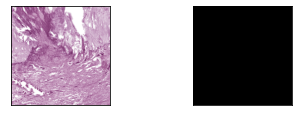

In [9]:
cols = 2
amt = 2
ax = plt.subplot(cols, amt, 1)
img = inp.squeeze()
img = img.detach().cpu().numpy()
plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(cols,amt, 2)
recon = decoded.squeeze()
print(recon.shape)
recon = recon.detach().cpu().numpy()
plt.imshow(np.transpose(recon, (1,2,0)))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

print(mse_running_total)

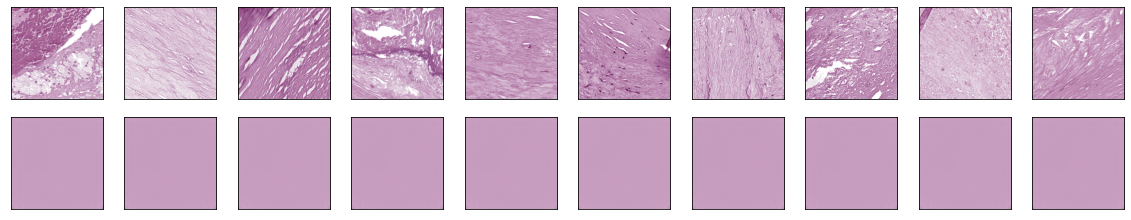

In [19]:
amt = 10
cols = 10
plt.figure(figsize=(20,20))


for k in range(amt):
    
    # input image
    ax = plt.subplot(cols, amt, k+1)
    img = auto_encoder_output[k][0].squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # recon image
    ax = plt.subplot(cols,amt, k+1+amt)
    recon = auto_encoder_output[k][1].squeeze()
    recon = recon.detach().cpu().numpy()
    plt.imshow(np.transpose(recon, (1,2,0)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [23]:
recon1, recon2 = auto_encoder_output[0][1], auto_encoder_output[1][1]

In [24]:
img - recon

tensor([[[[ 0.0700, -0.0141,  0.0523,  ...,  0.2355,  0.2235,  0.1462],
          [-0.0021,  0.0316, -0.0017,  ...,  0.1634,  0.1820,  0.1073],
          [ 0.0250,  0.0130, -0.0637,  ...,  0.1750,  0.1953,  0.1886],
          ...,
          [ 0.1930,  0.1401,  0.0880,  ...,  0.2176,  0.2501,  0.2405],
          [ 0.2610,  0.1921,  0.1773,  ...,  0.2376,  0.2531,  0.2549],
          [ 0.2294,  0.2254,  0.2349,  ...,  0.2551,  0.3026,  0.2894]],

         [[-0.1821, -0.2249, -0.1680,  ...,  0.1572,  0.0761, -0.0493],
          [-0.2401, -0.1576, -0.2067,  ...,  0.1059,  0.0769, -0.0179],
          [-0.1700, -0.1880, -0.2820,  ...,  0.1543,  0.1143,  0.1344],
          ...,
          [ 0.1201,  0.0316,  0.0156,  ...,  0.1471,  0.1863,  0.1696],
          [ 0.1810,  0.1386,  0.1044,  ...,  0.1756,  0.1389,  0.1269],
          [ 0.1012,  0.1849,  0.2071,  ...,  0.1931,  0.2289,  0.1937]],

         [[-0.0149, -0.0375, -0.0197,  ...,  0.2114,  0.1723,  0.0908],
          [-0.0682, -0.0123, -